In [51]:
from langchain_ollama import OllamaEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
import numpy as np
from utility import embed_dataset, print_processed_chunks, extract_descriptors, extract_all_descriptors, visualize_kp_on_img, compare_image, fit_Kmeans_model, build_histograms, embed_chunks_for_cosine, prepare_chunks_for_similarity, semantic_chunk_dataset
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans
import pandas as pd
import kagglehub


In [45]:
# CELL TO RELOAD UTILITY FILE

import importlib
import utility
importlib.reload(utility)

<module 'utility' from 'c:\\Users\\User\\SC4020 Project 1\\utility.py'>

# Part 1 Text Dataset Preprocessing

In [48]:
# For now I only take the first 3 rows for testing
df = pd.read_csv("News Article Dataset.csv")
article_texts = df["Article text"]
article_texts.head()

C:\Users\User\AppData\Local\Temp\ipykernel_2220\790870246.py:2: DtypeWarning: Columns (0,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,

0     (CNN)Right now, there's a shortage of truck d...
1     (CNN)Working in a factory or warehouse can me...
2     (CNN)In a Hong Kong warehouse, a swarm of aut...
3    New York (CNN Business)For many years, the wor...
4    The European Union formally approved on Tuesda...
Name: Article text, dtype: object

In [49]:
texts = article_texts.dropna().tolist()
texts = texts[:5]

# Chunk paragraphs of texts into semantic meanings
chunks = semantic_chunk_dataset(texts)

# Clean up each chunk using regex, then tokenize them for Jaccard, and ' '.joining them for cosine similarity embedding
preprocessed_chunks = prepare_chunks_for_similarity(chunks)

# Embed chunks[cleaned_text] into vectors
processed_chunks = embed_chunks_for_cosine(preprocessed_chunks)

In [50]:
print_processed_chunks(processed_chunks)

--- Chunk 1 ---
Original Text:  (CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and sever ...
Cleaned Text: cnnright now theres a shortage of truck drivers in the us and worldwide exacerbated by the ecommerce boom brought on by the pandemic one solution to the problem is autonomous trucks and several compan ...
Token Set: ['place', 'around', 'most', 'birkeland', '2015', '2019', 'province', 'carrier', 'cut', 'cities', 'launch', 'plush', 'without', 'hope', 'service', 'regular', 'rail', 'city', 'was', 'kilometers'] ...
Embedding Vector (first 10 values): [0.025109958, 0.027093848, -0.028489752, 0.026117349, 0.024269547, 0.011324266, -0.02171791, -0.0010936203, 0.04736905, 0.032958116]
Embedding Length: 1024

--- Chunk 2 ---
Original Text: The pickup and the dropoff were handled by a human driver, but for the bulk of the route -- from Tucson to Dalla

#### Workflow:
1) Chunk each row's paragraph using semantic chunk
2) Clean the text using regex (remove punctuations)
3) Tokenize the text for Jaccard similarity
4) Rejoin the tokenization to form "cleaned text"
5) Embed and vectorize the "cleaned text" and store it as [Embedding]

#### To do:
1) Using simple bag and set functionality to compare query text with processed_chunks[token_set]
2) For a query text, semantically chunk it, then embed it and compare embeddings with processed_chunks[embedding]

# Part 3 Image Similarity Search

In [19]:
# Download dataset, the path is a cached, so after running it once, you won't have to redownload it
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


In [29]:
# Extract the first 1000 images 

img_dir = os.path.join(path, "Images")
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
image_files = image_files[:1000]

In [36]:
# Get all descriptors from all images. Each image we will extract 500 features, so total should have 500000 descriptors.
# we can tune this to maybe have less features, since ORB really just detects sharp changes, increasing nfeatures-
# will not necessarily extract any features from the child

all_descriptors = extract_all_descriptors(image_files)

Extracting ORB features: 100%|██████████| 1000/1000 [00:27<00:00, 36.20it/s]

Extracted descriptors for 1000 images.


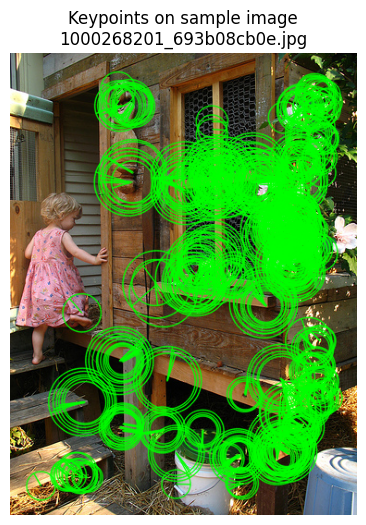

In [37]:
# Visualize keypoints on the first image

sample_img_path = image_files[0]
visualize_kp_on_img(sample_img_path)

In [38]:
# Run kmeans on the all_descriptors list to clusterize neighbouring descriptors into a cluster.
# The clusters will represent "visual words", for now I've set 200 clusters, we can probably increase this because we have 500000 amount of descriptors.

num_clusters = 500
kmeans = fit_Kmeans_model(all_descriptors, num_clusters)

In [39]:
# For each image, represent their descriptors as histograms. ie:
# For image 1, it has 5 descriptors that are nearest to cluster 0 hence:
    # cluster[0] = 5, and subsequently
    # cluster[1] = 0
    # cluster[2] = 10 etc etc, so an image will have total of num_clusters amount of bins, but each bin may >= 0 amount of "counts"


image_histograms = build_histograms(all_descriptors, kmeans, num_clusters)
binary_hist = (image_histograms > 0).astype(int)

Top 5 similar images:
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\1439046601_cf110a75a7.jpg (similarity: 0.459)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\1262077938_8b9516c273.jpg (similarity: 0.451)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\1460352062_d64fb633e0.jpg (similarity: 0.444)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\1304961697_76b86b0c18.jpg (similarity: 0.439)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\1679557684_50a206e4a9.jpg (similarity: 0.437)


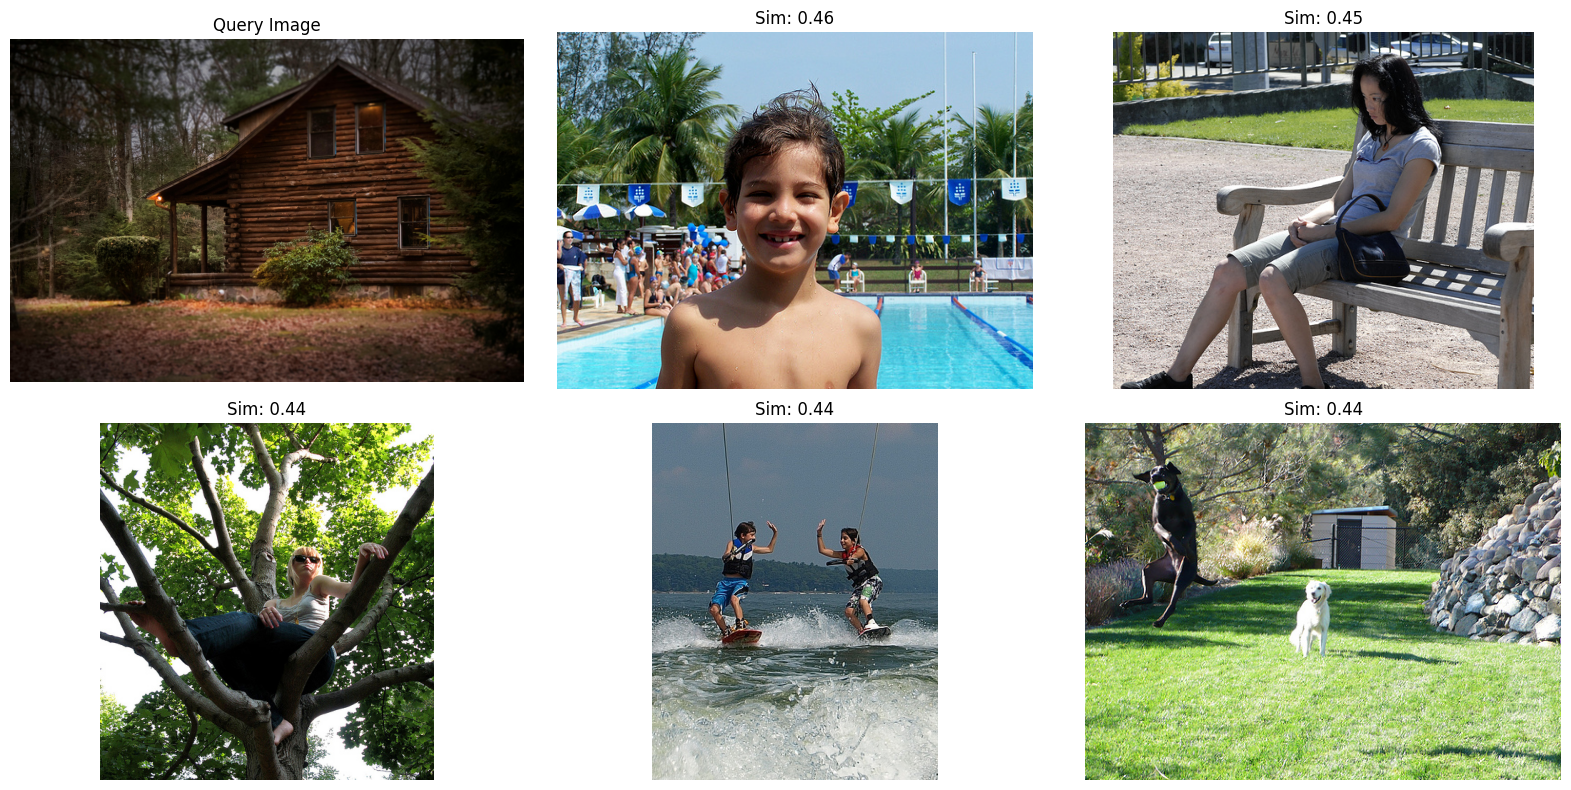

In [41]:
# Compare query image with the 1000 images. 
# Print top 5

compare_image("pexels-fariphotography-803975.jpg", kmeans, num_clusters, image_histograms, image_files)

Top 5 similar images:
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\197142902_f05ff198c2.jpg (similarity: 0.407)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\181777261_84c48b31cb.jpg (similarity: 0.402)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\2086532897_b8714f2237.jpg (similarity: 0.402)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\2051194177_fbeee211e3.jpg (similarity: 0.397)
C:\Users\User\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1\Images\201682811_105241dee3.jpg (similarity: 0.395)


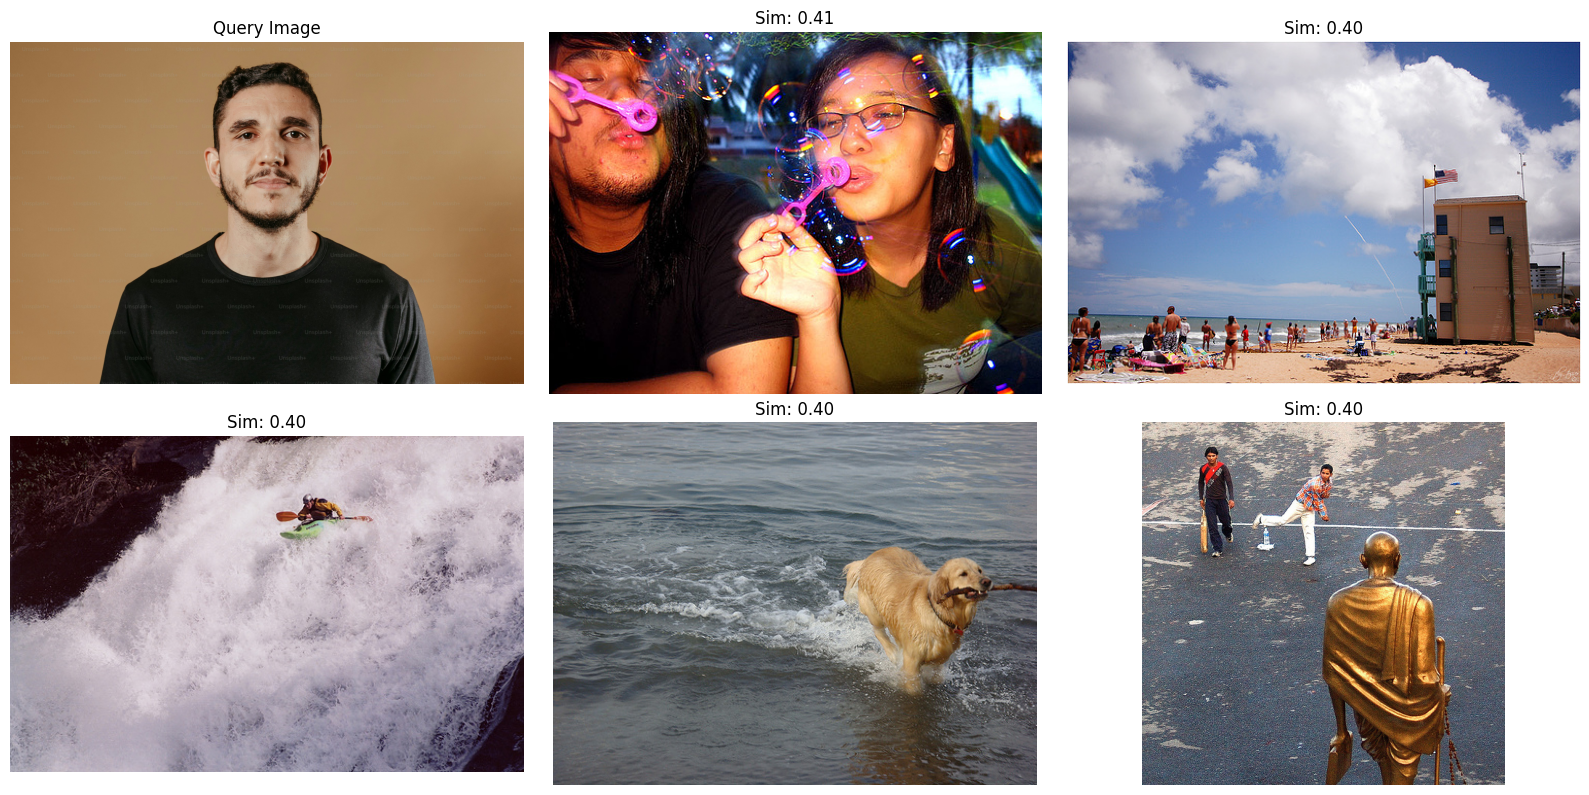

In [42]:
# Compare query image with the 1000 images. 
# Print top 5

compare_image("premium_photo-1689530775582-83b8abdb5020.jpg", kmeans, num_clusters, image_histograms, image_files)

#### Workflow:
1) download the dataset via kagglehub
2) extract the image paths as image_files
3) extract descriptors from all image and append them into one singular array called "all_descriptors"
4) run kmeans clustering on all the descriptors to get "num_clusters" number of "visual word representation"
5) represent each image's descriptors as histograms
6) binarize each histogram
7) compare a query image by extracting the query image's descriptors and finding out how many descriptors are in each clusters.
8) then simply compare no of descriptors in each cluster of the query image with all the dataset images to find top-k most similar. (Jaccard similarity)

#### To do:
1) convert each dataset image into vector of features using pretrained CNN models
2) convert query image the same way
3) compare similarity using cosine similarity between vectors